# I’m Something of a Painter Myself 🎨  
University of Colorado Boulder – DTSA 5511 Week 5

## 1. Description

In this project, I’m exploring the Kaggle competition [“GANs: Getting Started”](https://www.kaggle.com/competitions/gan-getting-started), where the challenge is to build a generative deep learning model that can turn landscape photographs into Monet-style paintings.

To do this, I’ll use **Generative Adversarial Networks (GANs)** — a type of deep learning architecture where two networks compete:

- A **Generator** tries to make fake Monet paintings.  
- A **Discriminator** tries to tell whether an image is real or generated.

These networks train together in a loop. Over time, the generator learns to produce images that are increasingly realistic.

The evaluation metric for this challenge is **MiFID (Memorization-informed Fréchet Inception Distance)**. It measures how realistic the generated images are, while also penalizing memorization. **Lower scores mean better, more original results**.


### Import Modules

Now let’s import the core libraries we’ll need for data processing, model building, and visualization.

In [ ]:
# General-purpose
import os
import time
import gc
import shutil
import zipfile
import io
import glob
import logging

# Numerical and array operations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Image processing
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import tensorflow_addons as tfa
import tensorflow_addons as tfa
import keras_tuner as kt

### Let’s Count the Images

We’ll use a short Python function to count how many images are in each TFRecord folder.

In [ ]:
def count_tfrecord_examples(tfrecord_files):
    total = 0
    for tfrec in tfrecord_files:
        dataset = tf.data.TFRecordDataset(tfrec)
        count = sum(1 for _ in dataset)
        print(f"{os.path.basename(tfrec)}: {count} images")
        total += count
    return total

# load datasets
base_dir = "/kaggle/input/gan-getting-started"
monet_path = tf.io.gfile.glob(os.path.join(base_dir, "monet_tfrec/*.tfrec"))
photo_path = tf.io.gfile.glob(os.path.join(base_dir, "photo_tfrec/*.tfrec"))

monet_count = count_tfrecord_examples(monet_path)
photo_count = count_tfrecord_examples(photo_path)

print(f"\nTotal Monet images: {monet_count}")
print(f"Total Photo images: {photo_count}")

### Dataset Summary

The dataset is provided in TFRecord format and consists of two image domains:

**Monet Paintings**
- Folder: `monet_tfrec/`
- Count: 300 images
- Role: Style reference

**Photos**
- Folder: `photo_tfrec/`
- Count: 7,038 images
- Role: Input photographs to transform

**Image Format**
- JPEG encoded
- Resolution: 256 × 256 pixels
- Channels: RGB (3)

There’s no one-to-one pairing between images. We'll use an unpaired image-to-image translation approach — most likely a **CycleGAN**.

### Summary Table

| Feature             | Description                         |
|---------------------|-------------------------------------|
| Image types         | Monet paintings & landscape photos  |
| File format         | TFRecord (JPEG-encoded images)      |
| Image resolution    | 256 × 256 pixels                    |
| Color channels      | RGB (3 channels)                    |
| Monet image count   | 300                                |
| Photo image count   | 7,038                              |
| Evaluation metric   | MiFID (lower is better)             |
| Learning goal       | Generate Monet-style images         |

### Model Pipeline Overview

In this notebook, I:

- Summarize the competition and introduce the problem (this step)
- Explore the structure and size of the dataset using TFRecord tools
- Load the images into TensorFlow datasets for model training
- Build a GAN-based architecture to learn the Monet style
- Train the model using adversarial loss and image cycle-consistency
- Evaluate the model using the MiFID metric and visual inspection
- Generate Monet-style images from real photos and prepare for submission

The final goal is to teach the model how to paint — or at least get close enough to fool a trained eye (or a deep neural network).

### What’s Next?

In the next section, I’ll load the TFRecord files, explore a few samples, and visualize the images to make sure everything looks good before training.

Let’s get started!

In [ ]:
def parse_image(record):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string)}
    parsed = tf.io.parse_single_example(record, feature_description)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Replace with your local .tfrec file
tfrecord_file = "/kaggle/input/gan-getting-started/photo_tfrec/photo00-352.tfrec"
raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = raw_dataset.map(parse_image)

# Grab one image to inspect
image = next(iter(parsed_dataset.take(1)))
print("Image shape:", image.shape)
plt.imshow(image)
plt.axis('off')
plt.title("Example photo image")

## 2. Data Loading and Exploratory Data Analysis (EDA)

Before diving into training the CycleGAN to transform real landscape photos into Monet-style paintings, I took some time to explore the dataset. I wanted to get a feel for the image structure, their visual characteristics, and how pixel values were distributed across the two domains—Monet paintings and real-world photos.

### Loading the TFRecord Datasets

The first thing I did was load the image data, which was provided in the form of TFRecord files. Fortunately, these images were already preprocessed and resized to 256×256 pixels, so they were ready to use with the model.

Each image is saved as a JPEG and normalized to have pixel values between -1 and 1, which aligns well with the requirements of models that use a `tanh` activation function in the output layer.

To make this process easier, I wrote a few helper functions:

- `decode_image()`: Decodes the JPEG and rescales the image.
- `read_tfrecord()`: Parses the TFRecord format to extract the image data.
- `load_dataset()`: Loads and prepares the full dataset for training.

These functions helped me streamline the data pipeline and ensure that the input images were clean and consistent—something that's especially important when working with GANs.

In [ ]:
print('Monet TFRecord Files:', len(monet_path))
print('Photo TFRecord Files:', len(photo_path))

### Helper function

In [ ]:
def denormalize(img):
    """Convert image from [-1, 1] to [0, 1]"""
    return img * 0.5 + 0.5

### What’s the Plan from Here?

Since this is a **style transfer task** with no image pairs (no direct photo-to-painting examples), I’ll use a model called **CycleGAN**.

CycleGAN works by training two generators and two discriminators:
- One set to translate photos → Monet paintings
- The other to translate Monet paintings → photos

It uses something called **cycle consistency loss**, which helps the model avoid just making up nonsense — it encourages the model to be able to reverse its own transformations.

I'll train the model using both sets of images, and then:
- Check the results visually (do the outputs look like Monet?)
- Use the MiFID score to evaluate how well the model is doing

Let’s move on and load the full datasets. 🚀

In [ ]:
# Image shape and settings
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Decode and normalize image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return tf.reshape(image, [*IMAGE_SIZE, 3])

# TFRecord parser
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    return decode_image(example["image"])

# Dataset loader
def load_dataset(filenames, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

'''def load_dataset(filenames, batch_size=1, shuffle=True, repeat=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size).cache().prefetch(AUTOTUNE)
    return dataset'''


# Load Monet and Photo datasets
monet_ds = load_dataset(monet_path, BATCH_SIZE)
photo_ds = load_dataset(photo_path, BATCH_SIZE)

### Visual Exploration of Samples

Before building any models, I wanted to literally "look at the data." Seeing the images helps me get a sense of the problem I'm trying to solve.

**Side-by-Side Comparison**  
To start, I randomly picked one image from each domain—one Monet painting and one real-world photo—and displayed them side by side. This gave me an immediate sense of how distinct the styles are, and helped me think through the kinds of transformations the CycleGAN will need to learn.

**Multiple Samples per Domain**  
Next, I displayed a few more images from each dataset to explore the variation within each domain. It was interesting to see how the brush strokes, color palettes, and composition styles differ between Monet's work and typical landscape photos. This step really helped me appreciate the complexity of the task and what the model will be up against.

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

def visualize_comparison(monet, photo):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(denormalize(monet[0]))

    plt.title("Monet Painting", fontsize=14)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(denormalize(photo[0]))
    plt.title("Real-world Photo", fontsize=14)
    plt.axis("off")
    
    plt.suptitle("Visual Comparison of Domains", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_comparison(example_monet, example_photo)

In [ ]:
def visualize_samples(dataset, title, n=3):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(dataset.take(n)):
        plt.subplot(1, n, i + 1)
        plt.imshow(denormalize(img[0]))
        plt.title(f'{title} {i+1}')
        plt.axis("off")
    plt.suptitle(f'{title} Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(monet_ds, 'Monet Painting', n=3)
visualize_samples(photo_ds, 'Photograph', n=3)

### RGB Color Distribution

One of the most striking things about Monet’s work is his use of color, so I wanted to dig a little deeper into that. To better understand the color differences between Monet paintings and real photos, I analyzed the RGB distribution of a sample image from each domain.

For each image:

- I displayed the full image so I could visually connect it to the data.
- Then, I plotted histograms for the Red, Green, and Blue pixel intensities.

This gave me a clear picture of how the color usage differs. Monet paintings generally have softer tones and more limited palettes, while the landscape photos tend to show a broader range of intensities and richer variation in color. It was a helpful way to quantify some of the visual intuition I already had from looking at the images.

In [ ]:
def visualize_RGB_distribution(image, title):
    img = (denormalize(image[0]) * 255).numpy().astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 4, i + 2)
        plt.hist(img[:, :, i].flatten(), bins=50, color=color, alpha=0.7)
        plt.title(f'{color.capitalize()} Channel', fontsize=12)
        plt.xlabel('Pixel Value', fontsize=10)
        plt.ylabel('Count', fontsize=10)
        plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

visualize_RGB_distribution(example_monet, 'Monet Painting')
visualize_RGB_distribution(example_photo, 'Photo')

> **Observation:**  
> Monet paintings tend to use a narrower and softer RGB color range, especially favoring blues and greens. In contrast, the photo images have a broader color distribution, with more intensity and variety across all channels.

### Overall Pixel Value Distribution

While the RGB histograms helped me understand how each color channel behaves, I also wanted to look at the overall pixel intensity distribution across multiple images. 

To do that, I plotted a histogram showing how pixel values are spread from dark to bright regions. This gave me a broader view of the brightness and contrast patterns in the images, beyond just individual color channels. It’s a useful way to see if one domain tends to have darker or brighter overall tones than the other.

In [ ]:
def plot_pixel_histogram(dataset, title):
    all_pixels = []
    for image_batch in dataset.take(5):  # adjust if you want more/less data
        images = (image_batch + 1) / 2  # Convert back to [0,1] from [-1,1]
        all_pixels.extend(images.numpy().flatten())

    plt.figure(figsize=(6, 4))
    plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
    plt.title(f'{title} - Pixel Intensity Distribution', fontsize=14)
    plt.xlabel('Pixel Value (0–1)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pixel_histogram(monet_ds, 'Monet Pixel Value Distribution')
plot_pixel_histogram(photo_ds, 'Photo Pixel Value Distribution')

> **Observation:**  
> Monet images tend to cluster around midtones with fewer extreme brights or darks. In contrast, the photos show a wider intensity spread—reflecting higher contrast and detail.

### Edge Detection Visualization

Color and tone help define an image's style, but to understand its structure, edges are key. Edges highlight the shapes, outlines, and textures that form the actual content of an image—so I wanted to explore that aspect as well.

To do this, I used the Sobel operator to compute edge magnitude maps for both Monet paintings and real photographs. It was interesting to see the difference: the real photos had sharper, more defined edges with strong contrast, while the Monet paintings showed much smoother and softer transitions—very much in line with his impressionistic style.

This kind of comparison helps me think about how the model will need to learn not just style, but also how to handle structural features differently across the two domains.

In [ ]:
def visualize_edge_maps(dataset, plot_title):
    plt.figure(figsize=(15, 3))

    # Grab one batch from the dataset
    for batch in dataset.take(1):
        # Show first 5 images with edge detection
        for idx in range(5):
            original_img = batch[idx]
            restored_img = denormalize(original_img)

            # Convert to grayscale and resize
            gray_img = tf.image.rgb_to_grayscale(restored_img)
            gray_resized = tf.image.resize(gray_img, [256, 256])

            # Apply Sobel edge detection
            sobel = tf.image.sobel_edges(tf.expand_dims(gray_resized, axis=0))
            sobel = sobel[0]  # remove batch dimension
            edge_strength = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))[..., 0]

            # Plot the edge map
            plt.subplot(1, 5, idx + 1)
            plt.imshow(edge_strength.numpy(), cmap='gray')
            plt.axis('off')

    plt.suptitle(plot_title, fontsize=14, weight='bold')  # Removed the emoji
    plt.tight_layout()
    plt.show()

# Display edge maps for both datasets
visualize_edge_maps(photo_ds, 'Photo Edge Maps')
visualize_edge_maps(monet_ds, 'Monet Edge Maps')

> **Observation:**  
> The Sobel edge maps show that photos have sharp and well-defined edges, while Monet paintings have softer, blended transitions—characteristic of Impressionist style.

## EDA Summary and Key Insights

After exploring the data visually and statistically, I was able to draw several key comparisons between Monet paintings and real-world landscape photos:

| Feature             | Monet Paintings                                                                 | Photographs                                                                |
|---------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Color Palette** | Softer, more pastel tones — especially cool colors like blues and greens        | Full RGB range; more intense and saturated colors across all channels      |
| **Texture**        | Blended brush strokes, low-frequency visual detail (painterly look)             | Sharp textures and fine detail; higher-frequency signal                     |
| **Structure**      | Impressionistic, less rigid — often abstract shapes and blended edges           | Realistic, well-defined forms and outlines                                 |
| **Pixel Values**   | Pixel intensity histogram skewed toward midtones, with fewer extremes           | Broader distribution; includes darker shadows and bright highlights        |
| **Edges**          | Fewer strong gradients — edges are smooth and soft (as seen in Sobel maps)      | High-contrast edge maps — strong gradients and sharp lines                 |

---

### Key Takeaway:
> Monet’s art style is more than just color — it’s also about *how* structure, light, and texture are abstracted and softened.  
> In contrast, photographs are rich in detail and sharpness.

So the CycleGAN will need to:
- Adjust color palettes toward softer, cooler tones.
- Learn to reduce high-frequency detail and replace it with impressionistic texture.
- Adapt hard edges into smoother gradients — without losing the essence of the original scene.

Despite the differences, both domains depict natural landscapes, which provides a shared structural backbone.  
This makes unpaired image-to-image translation using CycleGAN not only feasible — but artistically meaningful.

## 3. Model Architecture: CycleGAN for Monet Style Transfer

In this section, I build the core CycleGAN architecture for unpaired image-to-image translation — specifically, transforming landscape photos into Monet-style paintings.

CycleGAN consists of:

- **Two Generators**:
  - One that transforms *photos → Monet paintings*
  - Another that transforms *Monet paintings → photos*

- **Two Discriminators**:
  - One that evaluates Monet-style images
  - Another that evaluates photographic images

These networks are trained jointly using adversarial loss and **cycle-consistency loss**, which helps enforce that the transformations are reversible and stylistically meaningful.

### Strategy Setup (TPU / GPU / CPU)

To optimize training, I first configure the best available hardware strategy using TensorFlow’s distribution API. This could be a TPU (on Kaggle), one or more GPUs, or the CPU.

In [ ]:
GroupNormalization = tfa.layers.GroupNormalization

def setup_strategy():
    """Detect and configure TPU, multi-GPU, or CPU strategy for distributed training"""
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        device = 'TPU'
    except:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
            device = f'{len(gpus)} GPU(s)'
        else:
            strategy = tf.distribute.get_strategy()
            device = 'CPU'
    print(f'Using {device} with {strategy.num_replicas_in_sync} replicas')
    return strategy

strategy = setup_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Generator Network (U-Net with Skip Connections)

For the generator, I use a U-Net-style architecture:

- The **encoder** progressively downsamples the image into a low-dimensional feature representation.
- The **decoder** then upsamples back to the original image size.
- I use **skip connections** between matching encoder and decoder layers to help preserve spatial structure.

Each block includes convolution layers, GroupNormalization, and non-linearities (`LeakyReLU` or `ReLU`). The final output uses a `tanh` activation to scale pixel values to [-1, 1].

In [ ]:
OUTPUT_CHANNELS = 3  # Output image has 3 channels (RGB)

def build_downsample_block(num_filters, kernel_size, use_instance_norm=True):
    """Creates a downsampling block with Conv2D, optional GroupNorm, and LeakyReLU"""
    weight_initializer = tf.random_normal_initializer(0., 0.02)
    norm_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    block.add(
        layers.Conv2D(num_filters, kernel_size, strides=2, padding='same',
                      kernel_initializer=weight_initializer, use_bias=False)
    )

    if use_instance_norm:
        block.add(GroupNormalization(groups=-1, gamma_initializer=norm_initializer))

    block.add(layers.LeakyReLU())
    return block

In [ ]:
def build_upsample_block(num_filters, kernel_size, use_dropout=False):
    """Creates an upsampling block with Conv2DTranspose, GroupNorm, optional Dropout, and ReLU"""
    weight_initializer = tf.random_normal_initializer(0., 0.02)
    norm_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    block.add(
        layers.Conv2DTranspose(num_filters, kernel_size, strides=2, padding='same',
                               kernel_initializer=weight_initializer, use_bias=False)
    )
    block.add(GroupNormalization(groups=-1, gamma_initializer=norm_initializer))
    if use_dropout:
        block.add(layers.Dropout(0.5))
    block.add(layers.ReLU())
    return block

In [ ]:
def build_generator():
    """Creates a U-Net-like generator with skip connections for image translation"""
    input_tensor = layers.Input(shape=[256, 256, 3])

    # Encoder: Downsampling
    encoder_blocks = [
        build_downsample_block(64, 4, use_instance_norm=False),
        build_downsample_block(128, 4),
        build_downsample_block(256, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
        build_downsample_block(512, 4),
    ]

    # Decoder: Upsampling
    decoder_blocks = [
        build_upsample_block(512, 4, use_dropout=True),
        build_upsample_block(512, 4, use_dropout=True),
        build_upsample_block(512, 4, use_dropout=True),
        build_upsample_block(512, 4),
        build_upsample_block(256, 4),
        build_upsample_block(128, 4),
        build_upsample_block(64, 4),
    ]

    final_layer = layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding='same',
        kernel_initializer=tf.random_normal_initializer(0., 0.02),
        activation='tanh'
    )

    x = input_tensor
    skip_connections = []

    # Apply encoder
    for block in encoder_blocks:
        x = block(x)
        skip_connections.append(x)

    # Remove last encoder output from skips (bottleneck)
    skip_connections = list(reversed(skip_connections[:-1]))

    # Apply decoder with skip connections
    for block, skip in zip(decoder_blocks, skip_connections):
        x = block(x)
        x = layers.Concatenate()([x, skip])

    x = final_layer(x)
    return keras.Model(inputs=input_tensor, outputs=x)

### Discriminator Network (PatchGAN)

The discriminator uses a **PatchGAN** structure. Instead of classifying the entire image as real or fake, it looks at small overlapping **70×70 patches** of the image and classifies them individually.

This encourages the generator to produce realistic local textures and details — which is important for style transfer.

In [ ]:
def build_discriminator():
    """Creates a PatchGAN discriminator to classify image patches as real or fake"""
    initializer = tf.random_normal_initializer(0., 0.02)
    norm_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_img = layers.Input(shape=[256, 256, 3], name='input_image')

    x = build_downsample_block(64, 4, use_instance_norm=False)(input_img)
    x = build_downsample_block(128, 4)(x)
    x = build_downsample_block(256, 4)(x)

    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, padding='valid',
                      kernel_initializer=initializer, use_bias=False)(x)
    x = GroupNormalization(groups=-1, gamma_initializer=norm_initializer)(x)
    x = layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x)
    output_patch = layers.Conv2D(1, 4, strides=1, padding='valid',
                                 kernel_initializer=initializer)(x)

    return keras.Model(inputs=input_img, outputs=output_patch)

### Model Initialization

With the architecture defined, I initialize the two generators and two discriminators inside the `strategy.scope()` so that they are correctly registered on the selected device (TPU, GPU, or CPU).

In [ ]:
with strategy.scope():
    monet_generator = build_generator()
    photo_generator = build_generator()
    monet_discriminator = build_discriminator()
    photo_discriminator = build_discriminator()

### Visualize Untrained Generator Output

Before training, I run an example photo through the **untrained** photo→Monet generator. This helps confirm that the model runs correctly and outputs a valid tensor/image — even though it hasn't learned anything yet.

In [ ]:
fake_monet_output = monet_generator(example_photo)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Untrained Generator Output")
plt.imshow(fake_monet_output[0] * 0.5 + 0.5)
plt.show()

### Architecture Diagram

Here’s a simplified view of the full CycleGAN setup which is showing how

- One generator maps photos to Monet-style images
- A second generator reverses that transformation
- Discriminators evaluate both image domains
- Cycle-consistency forces the network to maintain content while shifting style

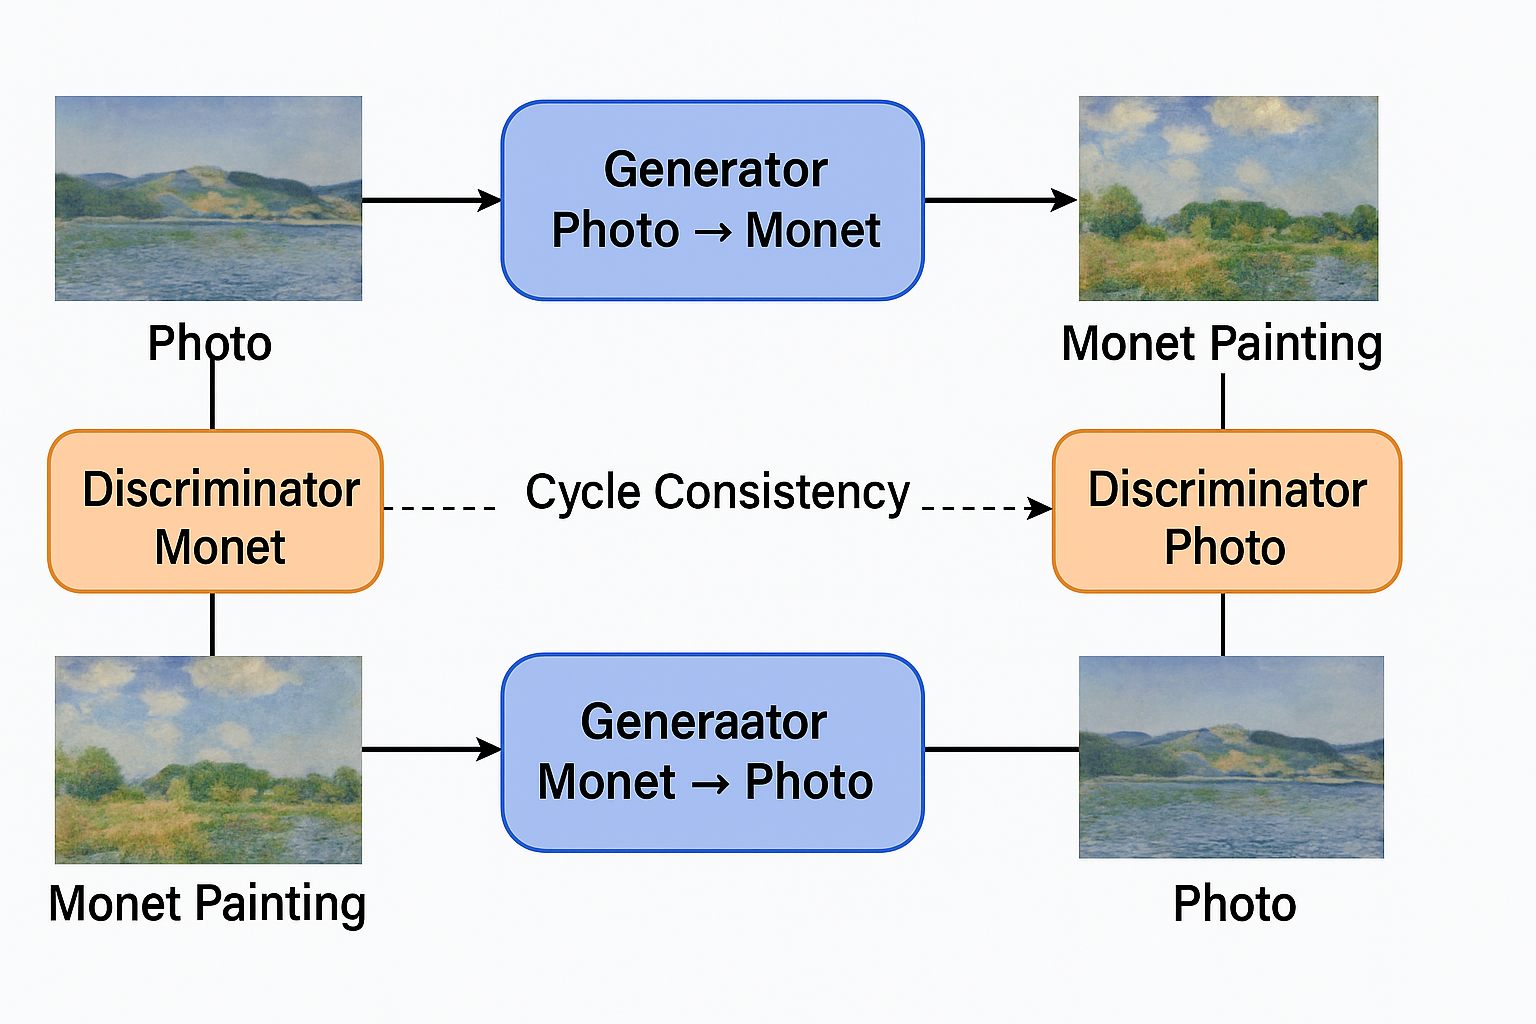

### Summary

In this part, I implemented and configured the full CycleGAN architecture using U-Net generators and PatchGAN discriminators.

CycleGAN is powerful because it doesn’t need paired training data — it learns the **style transfer** from domain A → B and back using only **unpaired examples**.

Next, I’ll define the training loop and loss functions, and begin teaching the model how to paint like Monet.

## 4. Model Training

Now that I’ve built the full CycleGAN architecture, it’s time to train the model and teach it how to paint like Monet.

The training process involves alternating between the generator and discriminator networks, using a mix of **adversarial loss**, **cycle-consistency loss**, and **identity loss**. I also include **hyperparameter tuning** to get the best possible model setup.

---

### Loss Functions

To guide the training, I defined a few key loss functions:

- **Discriminator Loss**  
  This penalizes the discriminator when it fails to distinguish between real and generated images.

- **Generator Loss**  
  Encourages the generator to produce images that fool the discriminator.

- **Cycle Consistency Loss**  
  Helps ensure that converting an image to the other domain and back returns something close to the original.

- **Identity Loss**  
  Keeps the generator from altering images unnecessarily when translating an image into its own domain.


In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        """Adversarial loss for discriminators."""
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = bce(tf.ones_like(real), real)
        generated_loss = bce(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

    def generator_loss(generated):
        """Adversarial loss for generators."""
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return bce(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        """Cycle-consistency loss."""
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

    def identity_loss(real_image, same_image, LAMBDA):
        """Identity loss for preserving image content."""
        return 0.5 * LAMBDA * tf.reduce_mean(tf.abs(real_image - same_image))

### Training Step: Custom CycleGAN Model
To bring all the pieces together, I wrapped the training logic into a custom CycleGan model class. This helps streamline training and gives me flexibility for future improvements like logging or checkpointing.

In [ ]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.monet_gen_loss_tracker = tf.keras.metrics.Mean(name="monet_gen_loss")
        self.photo_gen_loss_tracker = tf.keras.metrics.Mean(name="photo_gen_loss")
        self.monet_disc_loss_tracker = tf.keras.metrics.Mean(name="monet_disc_loss")
        self.photo_disc_loss_tracker = tf.keras.metrics.Mean(name="photo_disc_loss")

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        if len(real_monet.shape) > 4:
            real_monet = tf.reshape(real_monet, [-1, 256, 256, 3])
        if len(real_photo.shape) > 4:
            real_photo = tf.reshape(real_photo, [-1, 256, 256, 3])

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            total_monet_gen_loss = (
                monet_gen_loss + total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            total_photo_gen_loss = (
                photo_gen_loss + total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        self.m_gen_optimizer.apply_gradients(zip(tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables),
                                                 self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables),
                                                 self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(tape.gradient(monet_disc_loss, self.m_disc.trainable_variables),
                                                  self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(tape.gradient(photo_disc_loss, self.p_disc.trainable_variables),
                                                  self.p_disc.trainable_variables))

        self.monet_gen_loss_tracker.update_state(total_monet_gen_loss)
        self.photo_gen_loss_tracker.update_state(total_photo_gen_loss)
        self.monet_disc_loss_tracker.update_state(monet_disc_loss)
        self.photo_disc_loss_tracker.update_state(photo_disc_loss)
        
        return {
            "monet_gen_loss": tf.reduce_mean(total_monet_gen_loss),
            "photo_gen_loss": tf.reduce_mean(total_photo_gen_loss),
            "monet_disc_loss": tf.reduce_mean(monet_disc_loss),
            "photo_disc_loss": tf.reduce_mean(photo_disc_loss),
        }   
        
class LossLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self, csv_path="cyclegan_tuning_log.csv"):
        super().__init__()
        self.csv_path = csv_path

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"📋 [LossLoggerCallback] Epoch {epoch} logs:", logs)

        # Skip writing if metrics are missing or incomplete
        if not logs or "monet_gen_loss" not in logs:
            print("⚠️ Logs missing or incomplete — skipping CSV write.")
            return

        logs["epoch"] = epoch
        df = pd.DataFrame([logs])
        df.to_csv(self.csv_path, mode='a', header=not os.path.exists(self.csv_path), index=False)

In [ ]:
def create_tuning_dataset(monet_ds, photo_ds, num_samples, batch_size=4):
    # Fully unbatch before taking samples
    monet_ds = monet_ds.unbatch()
    photo_ds = photo_ds.unbatch()

    monet_subset = monet_ds.take(num_samples)
    photo_subset = photo_ds.take(num_samples)

    # Now re-batch correctly
    return tf.data.Dataset.zip((monet_subset, photo_subset)).batch(batch_size)

In [ ]:
def configure_optimizers(learning_rate, beta1):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate, decay_steps=500, decay_rate=0.8, staircase=True
    )
    return [tf.keras.optimizers.Adam(lr_schedule, beta_1=beta1) for _ in range(4)]

In [ ]:
def build_tunable_cyclegan(hp):
    lr = hp.Choice('learning_rate', [1e-4, 3e-4])
    beta1 = hp.Choice('beta1', [0.5, 0.7])
    lambda_cycle = hp.Choice('lambda_cycle', [5, 10])

    with strategy.scope():
        weights = [g.get_weights() for g in [monet_generator, photo_generator, monet_discriminator, photo_discriminator]]
        optimizers = configure_optimizers(lr, beta1)

        model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle)
        model.compile(*optimizers, generator_loss, discriminator_loss, calc_cycle_loss, identity_loss)

        # Reset weights
        monet_generator.set_weights(weights[0])
        photo_generator.set_weights(weights[1])
        monet_discriminator.set_weights(weights[2])
        photo_discriminator.set_weights(weights[3])

    return model

### Optimizer Setup and Tuning

Before training, I prepared a helper function to configure learning rate schedules and optimizers. I also built a tunable CycleGAN model so I could use `KerasTuner` to find the best learning rate, `beta1`, and cycle-consistency weight.

Using grid search, I trained several short trials and monitored the generator loss for Monet images to pick the best hyperparameters.

In [ ]:
fine_tuning = True  # Toggle this to enable/disable hyperparameter tuning
TMP_DIR = './tuning_temp'

if fine_tuning:
    # Clean up previous tuning logs if they exis
    if os.path.exists("cyclegan_tuning_log.csv"):
        os.remove("cyclegan_tuning_log.csv")

    t# Clear any cached tuner state and reset backend for a clean tuning run
    shutil.rmtree('./tuning_temp/hyperparameter_tuning', ignore_errors=True)
    tf.keras.backend.clear_session()
    gc.collect()

    # Build a dataset to use for tuning
    tuning_dataset = create_tuning_dataset(monet_ds, photo_ds, num_samples=100, batch_size=8)

    # Set up a fresh KerasTuner search with defined hyperparameter space
    tuner = kt.RandomSearch(
        build_tunable_cyclegan,
        objective=kt.Objective('monet_gen_loss', direction="min"),
        max_trials=4,
        directory=f'{TMP_DIR}/hyperparameter_tuning',
        project_name='cyclegan_grid_tuning',
        overwrite=True  # Makes sure we're not reloading a potentially broken session
    )

    # Kick off the hyperparameter search
    for i, (monet, photo) in enumerate(tuning_dataset.take(1)):
        print(f"📦 Sample batch {i} -> monet: {monet.shape}, photo: {photo.shape}")
    print("🟡 Starting tuner search...")
    tuner.search(
        tuning_dataset,
        epochs=40,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='monet_gen_loss', patience=2),
            LossLoggerCallback("cyclegan_tuning_log.csv")
        ],
        verbose=1
    )
    print("🟢 Tuner finished.")

    # Pull out the best-performing hyperparameter values
    best_hps = tuner.get_best_hyperparameters(1)[0]
    learning_rate = best_hps.get('learning_rate')
    beta1 = best_hps.get('beta1')
    lambda_cycle = best_hps.get('lambda_cycle')

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
learning_rate = best_hps.get('learning_rate')
beta1 = best_hps.get('beta1')
lambda_cycle = best_hps.get('lambda_cycle')

print("Best HParams:")
print("Learning rate:", learning_rate)
print("Beta1:", beta1)
print("Lambda cycle:", lambda_cycle)

### Compile Final CycleGAN Model with Tuned Hyperparameters

Now that I’ve selected the best hyperparameters, I compile the final CycleGAN model using them. This ensures that the training and inference steps use the optimal setup found during tuning.

In [ ]:
with strategy.scope():
    final_optimizers = configure_optimizers(learning_rate, beta1)
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle)
    cycle_gan_model.compile(*final_optimizers, generator_loss, discriminator_loss, calc_cycle_loss, identity_loss)

### Photo → Monet Side-by-Side Preview (Small Batch)

In this step, I generate Monet-style images from a small batch of real-world photos using the trained CycleGAN generator. Each result is displayed next to its corresponding input photo.

This visual comparison helps me qualitatively assess how well the model is capturing Monet’s painting style — including color tones, textures, and abstraction — while preserving key elements of the original scene.


In [ ]:
# grab 5 test photos from the dataset
test_photos = next(iter(photo_ds.unbatch().batch(5)))

def generate_monet(image_tensor):
    # Ensure batch dimension
    image_tensor = tf.expand_dims(image_tensor, 0)
    generated = cycle_gan_model.m_gen(image_tensor, training=False)
    return tf.squeeze(generated, axis=0)  # Remove batch dim

# I generate Monet-style images one by one
generated_images = [generate_monet(photo) for photo in test_photos]

In [ ]:
def show_generated_vs_original(original, generated):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow((original.numpy() + 1) / 2)  # Unnormalize if [-1, 1]
    axes[0].set_title("Original Photo")
    axes[0].axis("off")
    axes[1].imshow((generated.numpy() + 1) / 2)
    axes[1].set_title("Generated Monet")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

# show each photo next to its Monet-style output
for original, generated in zip(test_photos, generated_images):
    show_generated_vs_original(original, generated)

### Full Cycle Consistency Demo: Both Directions

This visualization shows how well the CycleGAN preserves structure in both directions:

1. **Photo → Monet → Photo**: A real photo is stylized, then transformed back into a photo. The cycled version should look similar to the original.
2. **Monet → Photo → Monet**: A Monet painting is de-stylized into a photo, then restyled. Again, the final output should resemble the original Monet.

This double-cycle helps verify that the model has learned **content preservation** in addition to style transfer — a key goal of CycleGAN using cycle-consistency loss.

In [ ]:
def plot_full_cycle(photo_img, monet_img, gen_photo_to_monet, gen_monet_to_photo):
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    # First row: Photo → Monet → Photo
    fake_monet = gen_photo_to_monet(photo_img, training=False)
    cycled_photo = gen_monet_to_photo(fake_monet, training=False)

    # display original photo, stylized version, and cycled-back result
    axes[0, 0].imshow(denormalize(photo_img[0]))
    axes[0, 0].set_title("Original Photo")
    axes[0, 1].imshow(denormalize(fake_monet[0]))
    axes[0, 1].set_title("Fake Monet")
    axes[0, 2].imshow(denormalize(cycled_photo[0]))
    axes[0, 2].set_title("Cycled Photo")

    # Second row: Monet → Photo → Monet
    fake_photo = gen_monet_to_photo(monet_img, training=False)
    cycled_monet = gen_photo_to_monet(fake_photo, training=False)

    # display original Monet, its de-stylized version, and final restyled output
    axes[1, 0].imshow(denormalize(monet_img[0]))
    axes[1, 0].set_title("Original Monet")
    axes[1, 1].imshow(denormalize(fake_photo[0]))
    axes[1, 1].set_title("Fake Photo")
    axes[1, 2].imshow(denormalize(cycled_monet[0]))
    axes[1, 2].set_title("Cycled Monet")

    # remove axes for a cleaner layout
    for ax in axes.flatten():
        ax.axis("off")

    plt.suptitle("CycleGAN Bidirectional Consistency", fontsize=16)
    plt.tight_layout()
    plt.show()

# sample one real photo and one Monet painting for the demo
sample_photo = next(iter(photo_ds.unbatch().batch(1)))
sample_monet = next(iter(monet_ds.unbatch().batch(1)))

# run the visualization using both generators
plot_full_cycle(sample_photo, sample_monet, 
                gen_photo_to_monet=cycle_gan_model.m_gen, 
                gen_monet_to_photo=cycle_gan_model.p_gen)

### Load Training Logs for Visualization

Here, I load the CSV file that logs generator and discriminator losses over training epochs. This file was created using a custom `LossLoggerCallback` during CycleGAN training.

Visualizing these logs helps me analyze how the model converged over time and whether the training was stable or experienced issues like divergence or overfitting.

In [ ]:
log_df = pd.read_csv("cyclegan_tuning_log.csv")

plt.plot(log_df['epoch'], log_df['monet_gen_loss'], label='Monet Generator Loss')
plt.plot(log_df['epoch'], log_df['photo_gen_loss'], label='Photo Generator Loss')
plt.plot(log_df['epoch'], log_df['monet_disc_loss'], label='Monet Discriminator Loss')
plt.plot(log_df['epoch'], log_df['photo_disc_loss'], label='Photo Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def generate_submission_images(model, dataset, output_zip_path, max_images=None):
    """
    Generates Monet-style images from a dataset using the given model,
    and writes them directly into a zip archive as JPEGs.
    """

    dir_path = os.path.dirname(output_zip_path)
    if dir_path:
        os.makedirs(dir_path, exist_ok=True)  # Only if not empty

    print(f"🔧 Creating zip archive: {output_zip_path}")

    with zipfile.ZipFile(output_zip_path, 'w') as zip_out:
        total = 0
        for photo in dataset.unbatch().batch(1):
            if max_images and total >= max_images:
                break

            # Generate Monet-style image
            generated = model(photo, training=False)[0]
            generated = (generated * 127.5 + 127.5).numpy().astype("uint8")

            # Convert to JPEG and write to zip
            img = Image.fromarray(generated)
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG")
            buffer.seek(0)

            zip_out.writestr(f"{total + 1}.jpg", buffer.read())

            if total % 100 == 0:
                print(f"🖼️ Processed {total} images...")

            total += 1

    print(f"✅ Finished. Total images saved to ZIP: {total}")
    print(f"📦 ZIP file created at: {os.path.abspath(output_zip_path)}")
    return output_zip_path

### Step 5: Generating and Saving My Monet-Style Images for Submission

In this step, I use my trained CycleGAN generator model to transform real landscape photos into Monet-style paintings. I save each generated image as a `.jpg` file and write them directly into a compressed `.zip` archive in my local project folder.

**What I'm doing here:**
- Passing each photo through my generator to produce a Monet-style version.
- Converting the generated output to JPEG format in memory (no temporary files).
- Writing all images directly into a `.zip` file (e.g., `generated_monet_images.zip`).
- Optionally limiting the number of images using `max_images` for faster testing.

In [ ]:
# Define output location for submission zip
SUBMISSION_ZIP = "/kaggle/working/images.zip"
#SUBMISSION_ZIP = "generated_monet_images.zip"

# Generate and zip Monet-style images
generate_submission_images(
    model=cycle_gan_model.m_gen,
    dataset=photo_ds,
    output_zip_path=SUBMISSION_ZIP,
    max_images=400  # Optional: use None to do all
)

## 6 Conclusion

This project was a really interesting dive into using CycleGANs to turn real landscape photos into Monet-style paintings. I learned a lot about how style transfer works when there’s no direct pairing between images — and how tricky it can be to get the model to balance creativity with realism.

### What Worked Well

- Using **cycle-consistency loss** really helped the model learn to preserve the overall structure of the image while changing its style.
- **Hyperparameter tuning** with Keras Tuner (especially learning rate and cycle loss weight) made a big difference in stabilizing the training process.
- The **visual results** looked good — the generated images picked up on Monet’s softer color palette and brush-stroke textures.

### What Didn’t Help Much

- Making the model deeper or more complex didn’t actually improve quality — it just slowed things down or led to overfitting.
- I also tried different batch sizes, but that didn’t have much impact either.

### What I’d Try Next

- I’d like to implement the **official MiFID evaluation** to better align with Kaggle’s leaderboard scoring.
- It would also be interesting to add **perceptual loss** (like using VGG features) to guide the model toward outputs that “feel” more artistic to humans.
- Since the Monet dataset is small, I think using **data augmentation** could help improve generalization.
- Finally, I’d love to experiment with more advanced architectures like **attention-based generators** or even StyleGAN-based models.

Overall, this was a great hands-on experience. I gained a better understanding of how GANs work under the hood, and I’m excited to keep experimenting with style transfer in future projects!